In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import matplotlib
import scipy.stats as scs

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
from itertools import product

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['lines.linewidth'] = 1.0

In [2]:
df = pd.read_excel('us_uninstall_20190831.xlsx', index_col=0, parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 591 entries, 2018-01-01 to 2019-08-14
Data columns (total 7 columns):
All countries    591 non-null int64
Vietnam          591 non-null int64
Brazil           591 non-null int64
Russia           591 non-null int64
Philippines      591 non-null int64
United States    591 non-null int64
Thailand         591 non-null int64
dtypes: int64(7)
memory usage: 36.9 KB


In [3]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
data = df['us']

# Stationarize

In [5]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

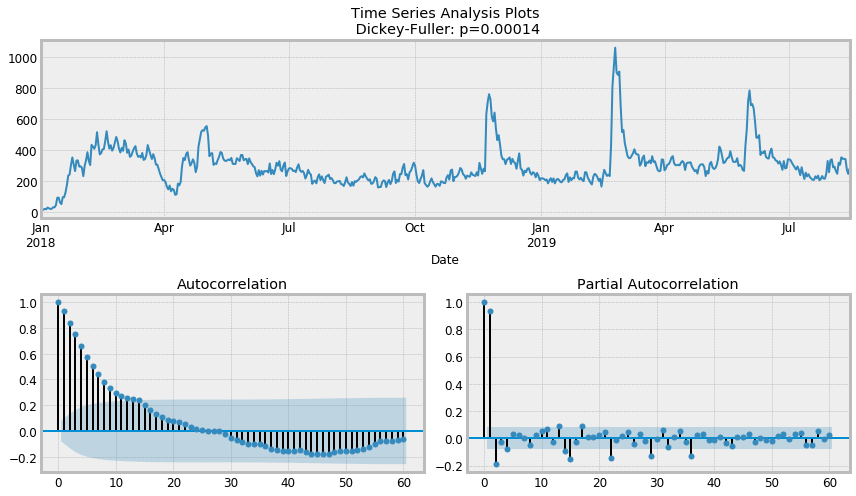

In [6]:
tsplot(data, lags=60)

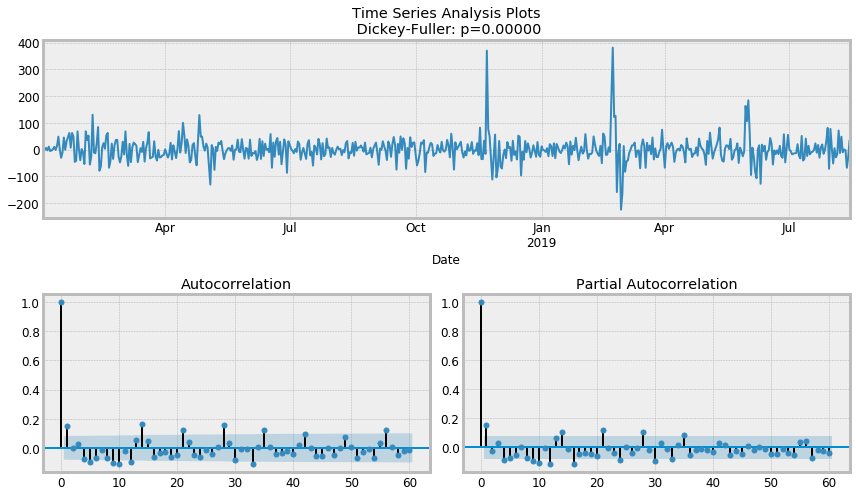

In [7]:
d_shifted = 1

df_diff = data - data.shift(d_shifted)
tsplot(df_diff[d_shifted:], lags=60)

# SARIMA

In [8]:
ps = range(1, 4)
d=1 
qs = range(0, 3)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 7 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [9]:
def optimizeSARIMA(data, parameters_list, d, D, s):
  """
    Return dataframe with parameters and corresponding AIC
    
    data - list with data of uninstall
    parameters_list - list with (p, q, P, Q) tuples
    d - integration order in ARIMA model
    D - seasonal integration order 
    s - length of season
  """
  results = []
  best_aic = float("inf")

  for param in tqdm_notebook(parameters_list):
      # we need try-except because on some combinations model fails to converge
      try:
          model=sm.tsa.statespace.SARIMAX(data, order=(param[0], d, param[1]), 
                                          seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
      except:
          continue
      aic = model.aic
      # saving best model, AIC and parameters
      if aic < best_aic:
          best_model = model
          best_aic = aic
          best_param = param
      results.append([param, model.aic])

  result_table = pd.DataFrame(results)
  result_table.columns = ['parameters', 'aic']
  # sorting in ascending order, the lower AIC is - the better
  result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
  
  return result_table

In [10]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);
    
    return pd.DataFrame(forecast)
    

In [11]:
from tqdm import tqdm_notebook
result_table = optimizeSARIMA(data,parameters_list, d, D, s)

In [12]:
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data,
                                       order=(p, d, q),
                                       seasonal_order=(P, D, Q, s))\
                                       .fit(disp=-1)

,0
2019-08-15,294.216574
2019-08-16,292.831240
2019-08-17,329.654849
2019-08-18,337.060943
2019-08-19,316.466766
2019-08-20,307.994923
2019-08-21,310.134279
2019-08-22,311.315866
2019-08-23,315.235461
2019-08-24,338.765757


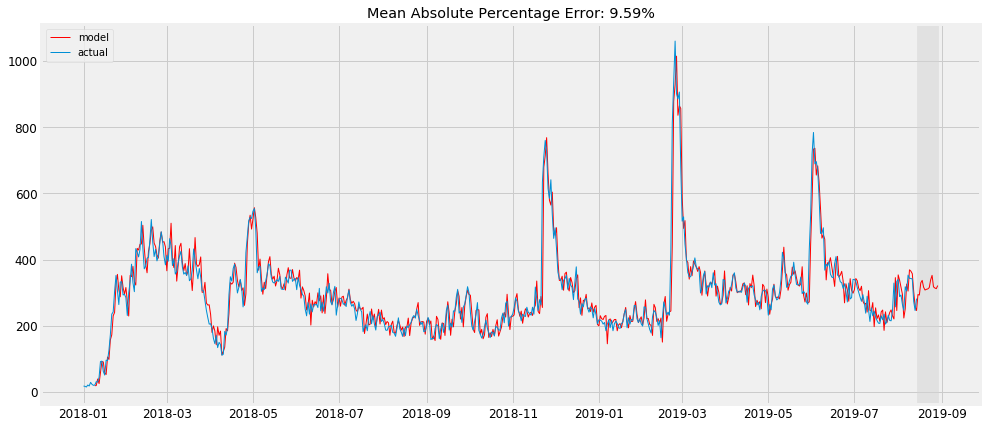

In [13]:
plotSARIMA(pd.DataFrame(data), best_model, 14).tail(15)

# Linear Models with time lags

## Preprocessing

In [70]:
lag_range = [7, 17]

In [71]:
lm_data = pd.DataFrame(data)
lm_data.columns = ['y']

In [72]:
for i in range(lag_range[0], lag_range[1]):
  lm_data['lag_{}'.format(i)] = lm_data.y.shift(i)

In [73]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

tscv = TimeSeriesSplit(n_splits=5)
tscv

TimeSeriesSplit(max_train_size=None, n_splits=5)

In [74]:
def timeseries_train_test_split(X, y, test_size):
  test_index = int(len(X) * (1-test_size))
  
  X_train = X.iloc[:test_index]
  y_train = y.iloc[:test_index]
  X_test = X.iloc[test_index:]
  y_test = y.iloc[test_index:]
  
  return X_train, X_test, y_train, y_test

In [75]:
y = lm_data.dropna().y
X = lm_data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

## Functions

In [76]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(10, 5))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

## Linear Regression

In [77]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

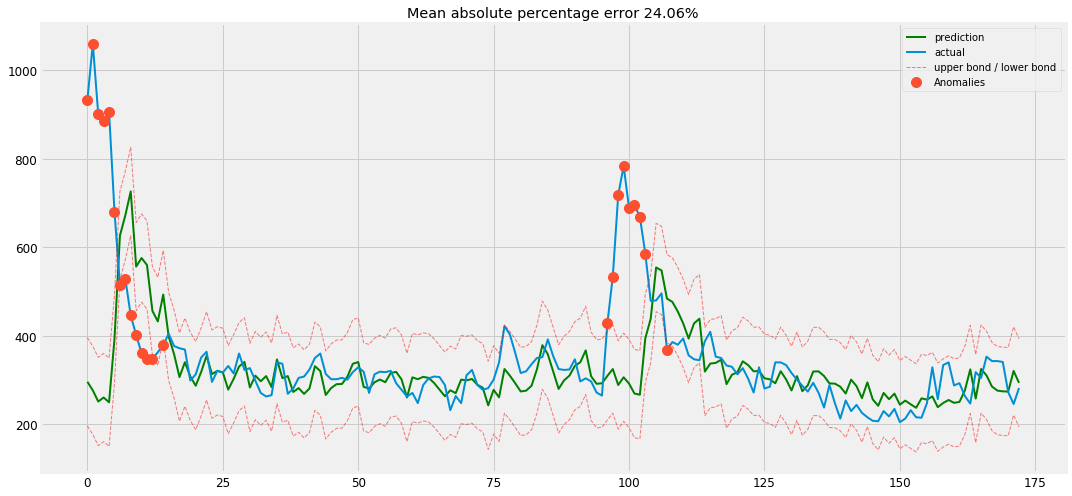

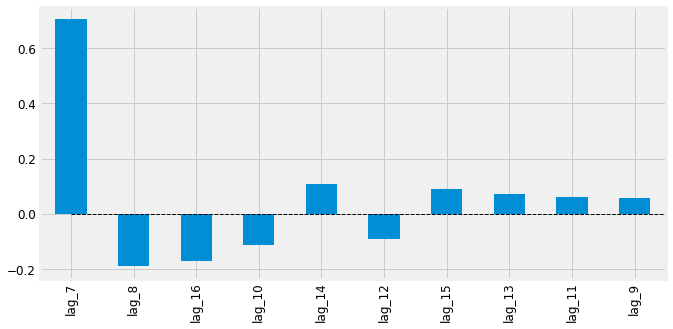

In [78]:
plotModelResults(model, plot_intervals=True, plot_anomalies=True)
plotCoefficients(model)

## Featues Extracting and Scaling

In [79]:
lm_data.index = pd.to_datetime(lm_data.index)
# lm_data['day'] = lm_data.index.day
lm_data['weekday'] = lm_data.index.weekday
lm_data['is_weekend'] = lm_data.weekday.isin([4,5])*1
lm_data.tail()

,y,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,weekday,is_weekend
Date,,,,,,,,,,,,,
2019-08-10,343,293.0,288.0,340.0,334.0,257.0,329.0,248.0,215.0,216.0,232.0,5,1
2019-08-11,341,264.0,293.0,288.0,340.0,334.0,257.0,329.0,248.0,215.0,216.0,6,0
2019-08-12,273,247.0,264.0,293.0,288.0,340.0,334.0,257.0,329.0,248.0,215.0,0,0
2019-08-13,246,318.0,247.0,264.0,293.0,288.0,340.0,334.0,257.0,329.0,248.0,1,0
2019-08-14,282,305.0,318.0,247.0,264.0,293.0,288.0,340.0,334.0,257.0,329.0,2,0


In [80]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

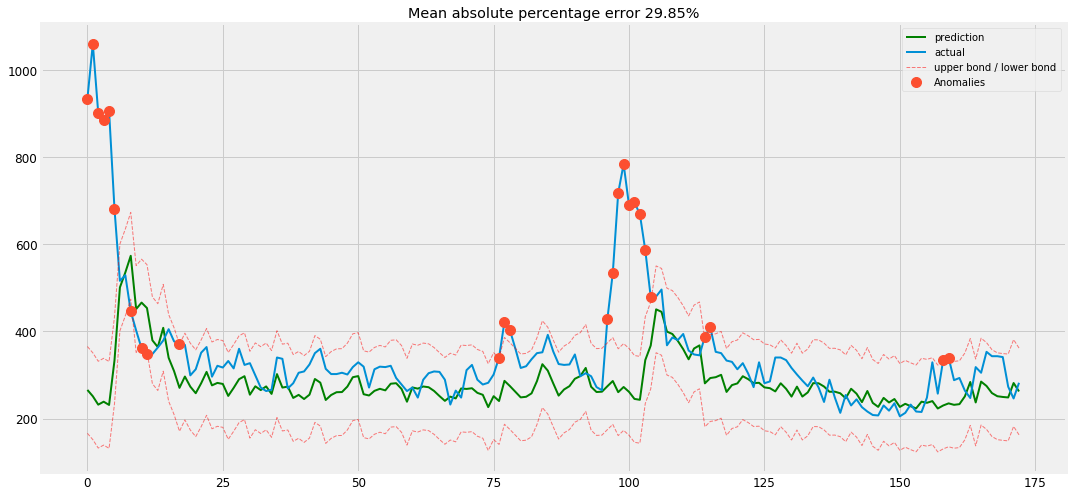

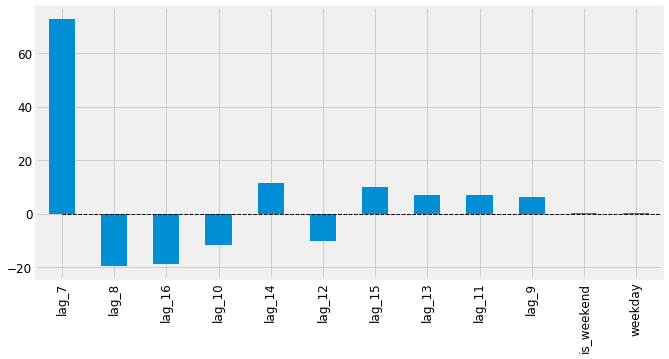

In [81]:
y = lm_data.dropna().y
X = lm_data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

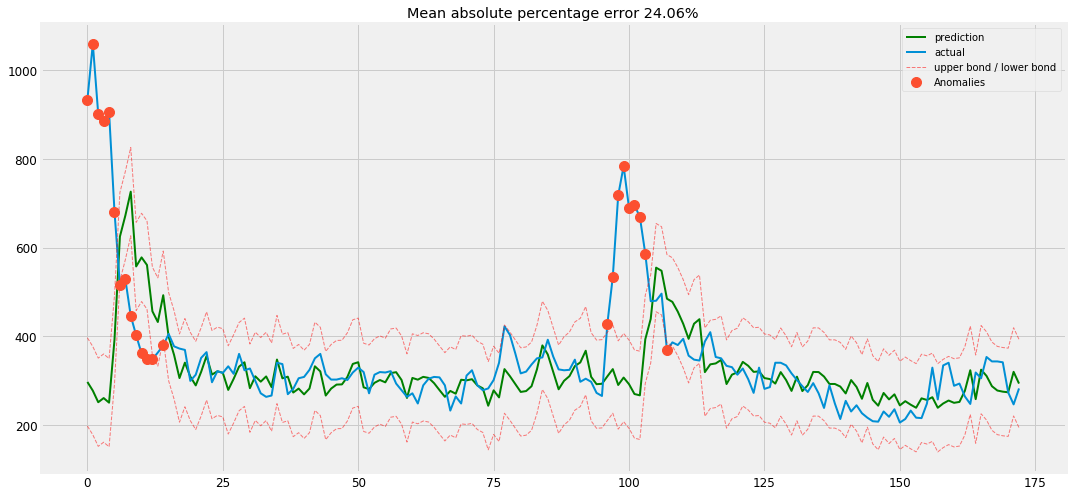

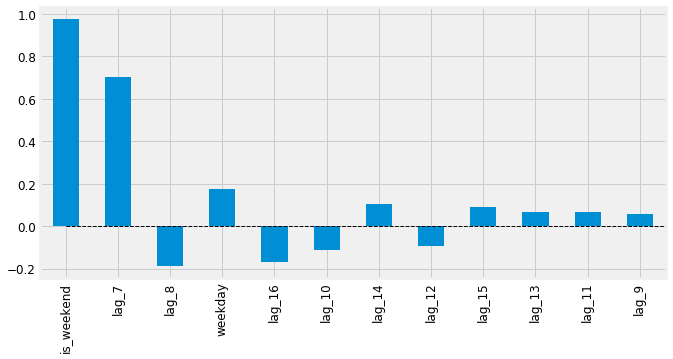

In [82]:
lr.fit(X_train, y_train)

plotModelResults(lr, X_train=X_train, X_test=X_test, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

## Ridge And Lasso

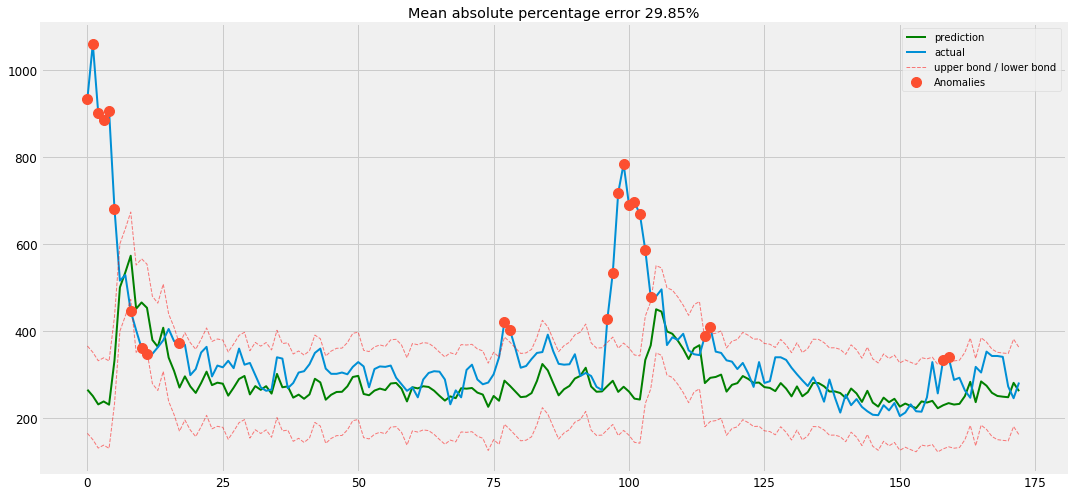

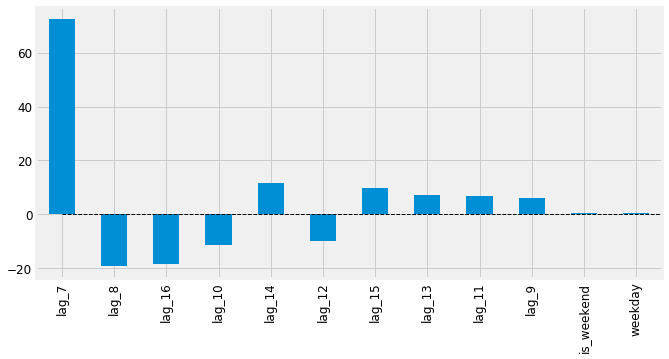

In [83]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge_s = RidgeCV(cv=tscv)
ridge_s.fit(X_train_scaled, y_train)

plotModelResults(ridge_s,
                 X_train=X_train_scaled,
                 X_test=X_test_scaled,
                 plot_intervals=True,
                 plot_anomalies=True)
plotCoefficients(ridge_s)

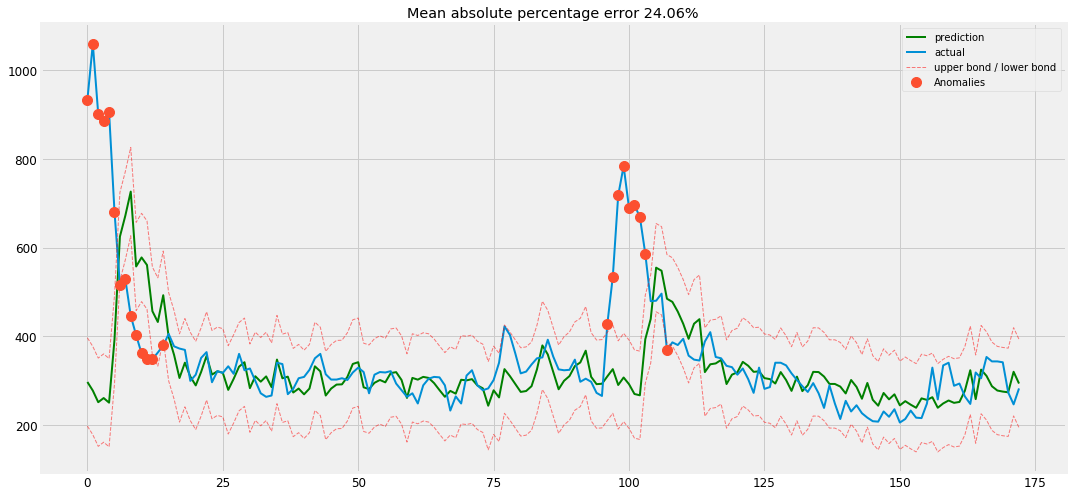

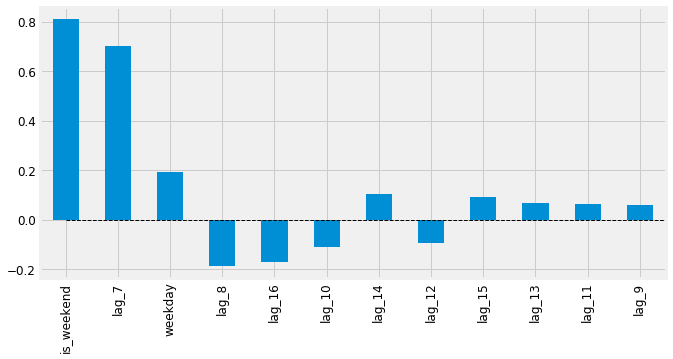

In [84]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train, y_train)

plotModelResults(ridge,
                 X_train=X_train,
                 X_test=X_test,
                 plot_intervals=True,
                 plot_anomalies=True)
plotCoefficients(ridge)

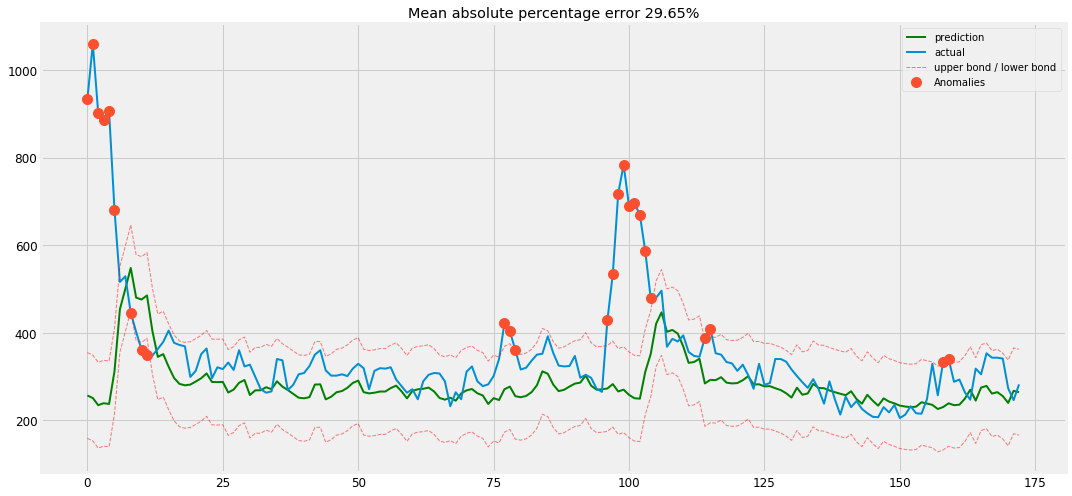

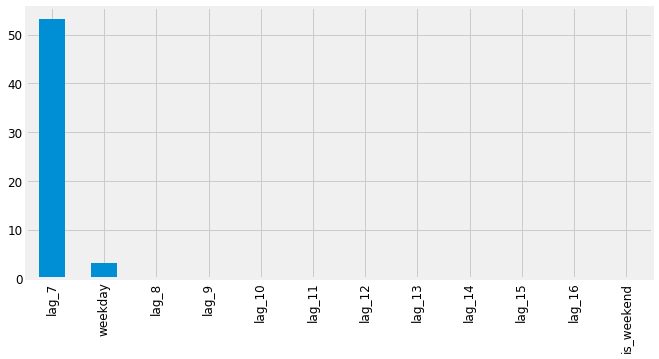

In [85]:
lasso_s = LassoCV(cv=tscv)
lasso_s.fit(X_train_scaled, y_train)

plotModelResults(lasso_s,
                 X_train=X_train_scaled,
                 X_test=X_test_scaled,
                 plot_intervals=True,
                 plot_anomalies=True)

plotCoefficients(lasso_s)

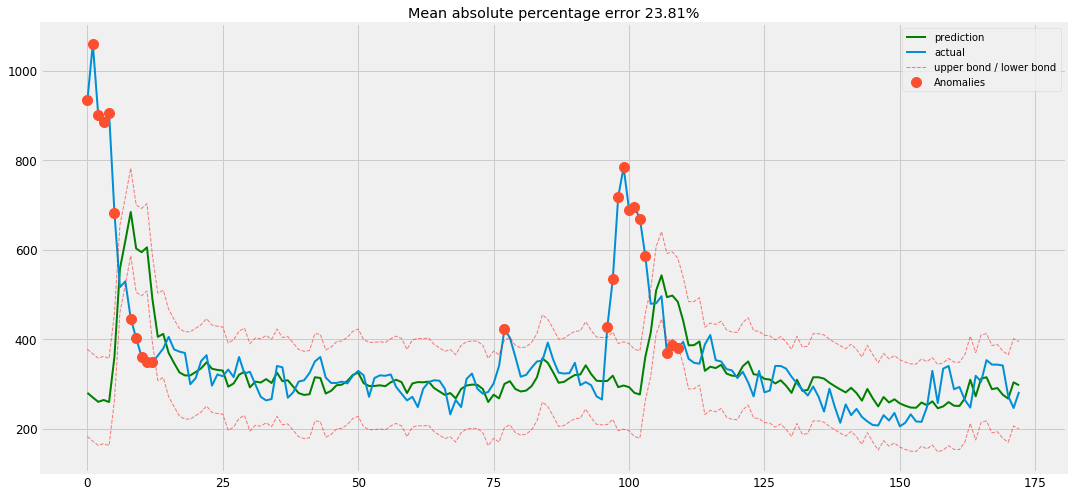

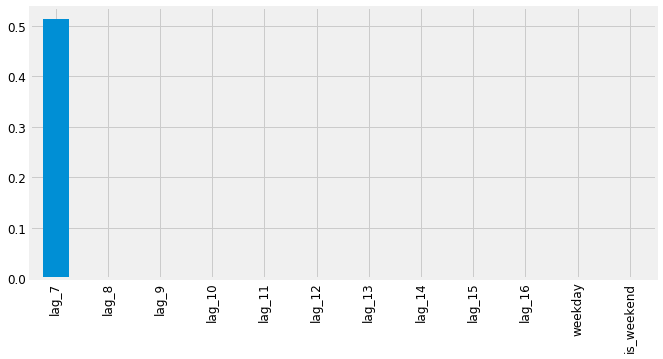

In [86]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train, y_train)

plotModelResults(lasso,
                 X_train=X_train,
                 X_test=X_test,
                 plot_intervals=True,
                 plot_anomalies=True)

plotCoefficients(lasso)

## Gradient Boosting Regression

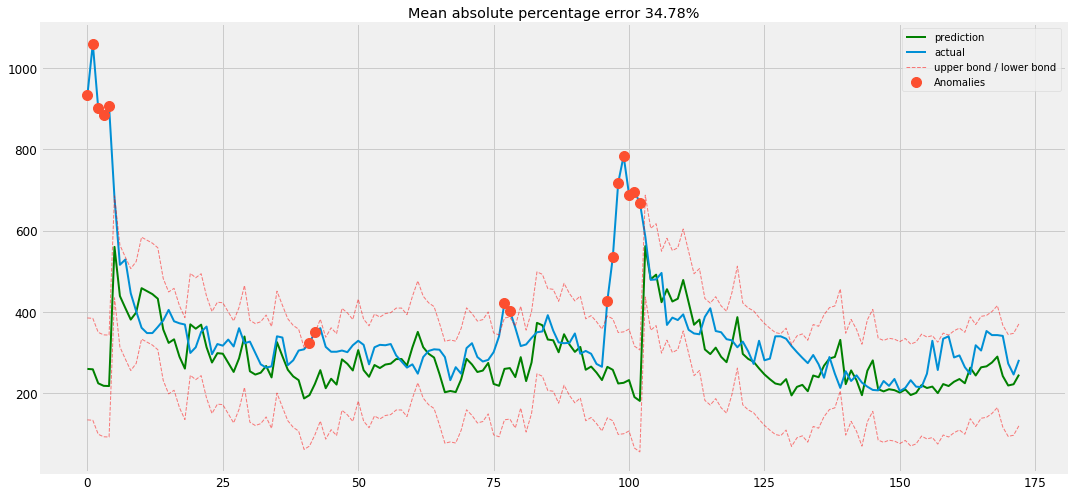

In [87]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_s = GradientBoostingRegressor()
gbr_s.fit(X_train_scaled, y_train)

plotModelResults(gbr_s,
                 X_train=X_train_scaled,
                 X_test=X_test_scaled, 
                 plot_intervals=True,
                 plot_anomalies=True
                )

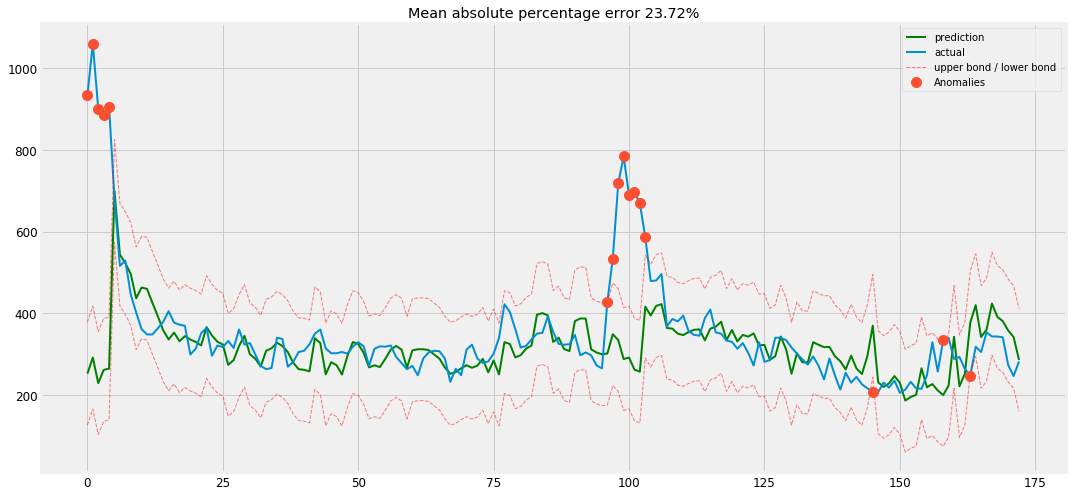

In [88]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

plotModelResults(gbr,
                 X_train=X_train,
                 X_test=X_test,
                 plot_intervals=True,
                 plot_anomalies=True
                )

[14:33:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


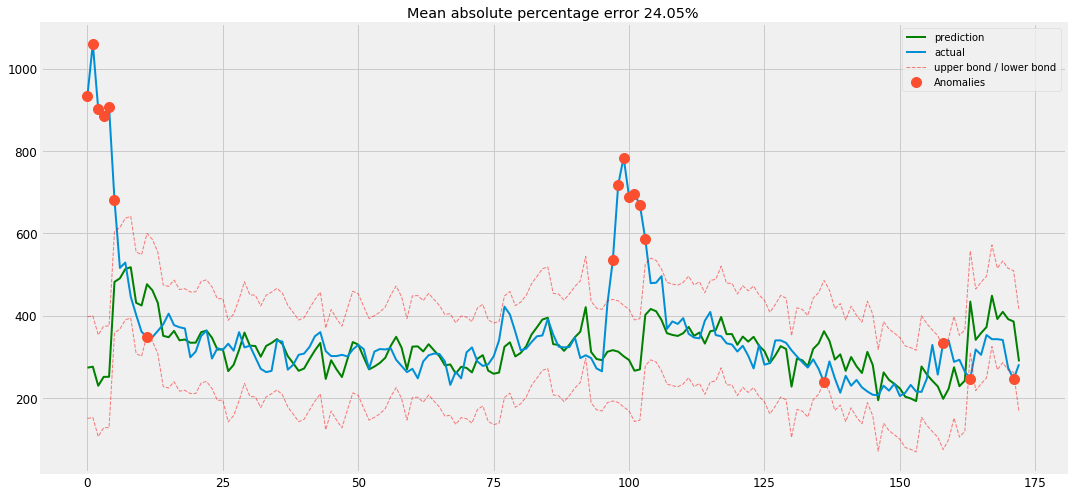

In [89]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

plotModelResults(xgb,
                X_train=X_train,
                X_test=X_test,
                plot_intervals=True,
                plot_anomalies=True)

[14:33:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


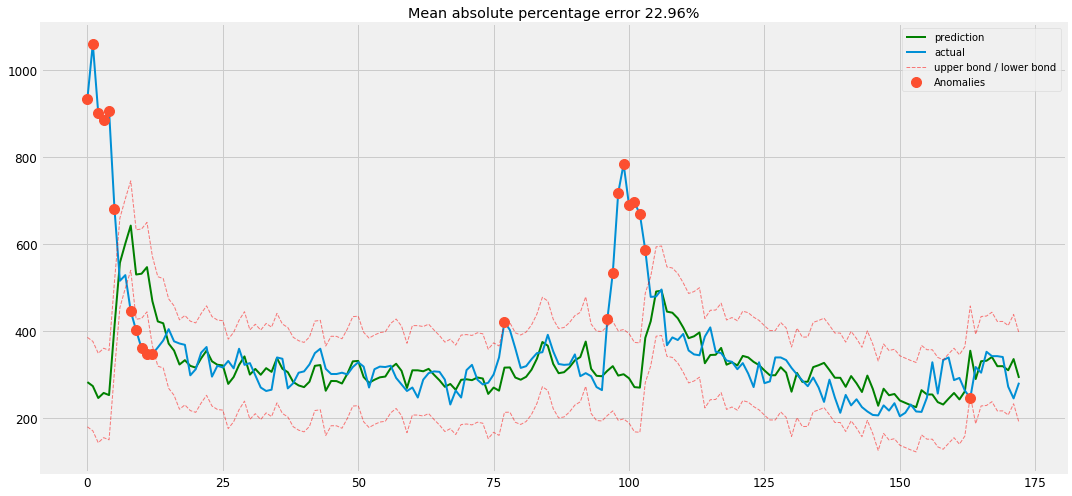

In [90]:
from sklearn.ensemble import VotingRegressor

reg1 = RidgeCV(cv=tscv)
reg2 = LassoCV(cv=tscv)
reg3 = XGBRegressor(random_state=1)

vr = VotingRegressor(estimators=[('ridge', reg1), ('lasso', reg2), ('gbr', reg3)])
vr = vr.fit(X_train, y_train)

plotModelResults(vr,
                X_train=X_train,
                X_test=X_test,
                plot_intervals=True,
                plot_anomalies=True)

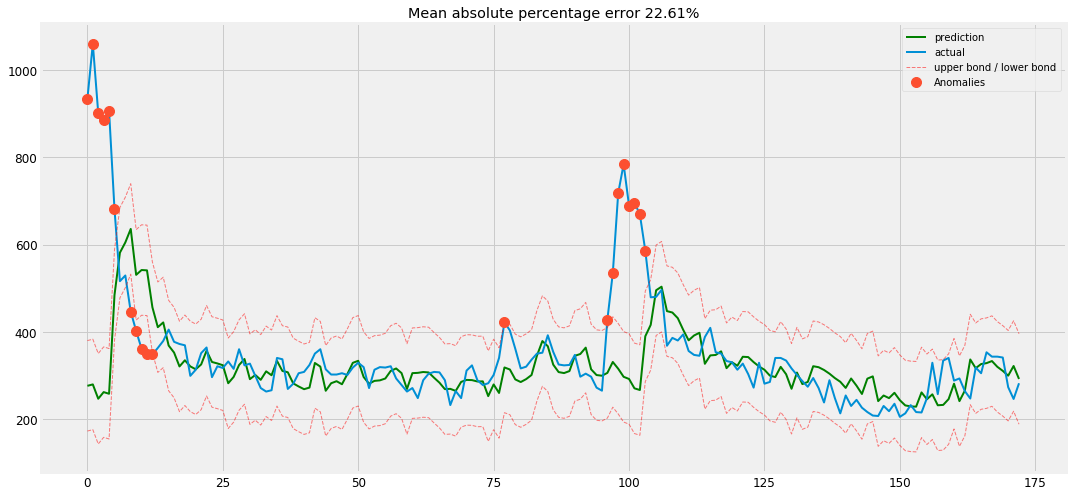

In [91]:
from sklearn.ensemble import VotingRegressor

reg1 = RidgeCV(cv=tscv)
reg2 = LassoCV(cv=tscv)
reg3 = GradientBoostingRegressor(random_state=1)

vr = VotingRegressor(estimators=[('ridge', reg1), ('lasso', reg2), ('gbr', reg3)])
vr = vr.fit(X_train, y_train)

plotModelResults(vr,
                X_train=X_train,
                X_test=X_test,
                plot_intervals=True,
                plot_anomalies=True)

plt.savefig('voting_us_7.png')

In [66]:
import pickle

with open('us_voting_regression_7.pkl', 'wb') as handle:
    pickle.dump(lasso, handle, pickle.HIGHEST_PROTOCOL)

## Predictions

In [67]:
p_df = pd.read_excel('country_uninstall_tp_1.xlsx', index_col=0, parse_dates=True)
p_data = pd.DataFrame(p_df['United States'].copy())
p_data.columns = ['y']

for i in range(lag_range[0], lag_range[1]):
  p_data['lag_{}'.format(i)] = p_data.y.shift(i)

X = p_data.dropna().drop(['y'], axis=1)

X.index = pd.to_datetime(X.index)
# X['day'] = X.index.day
X['weekday'] = X.index.weekday
X['is_weekend'] = X.weekday.isin([4,5,6])*1
p_data

,y,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14
Date,,,,,,,,,,,
2019-08-01,340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-02,288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-03,293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-04,264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-05,247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-06,318,340.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-07,305,288.0,340.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-08,353,293.0,288.0,340.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-09,343,264.0,293.0,288.0,340.0,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
pred = ridge.predict(X)

pd.DataFrame(pred)

ValueError: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required.

In [ ]:
X_scaled = scaler.fit_transform(X)
pred_s = xgb_s.predict(X_scaled)
pd.DataFrame(pred_s)